Sistem Kontrolü: cpu üzerinde çalışılıyor.
Resim dosyaları taranıyor...
Bulunan Resim Sayısı: 88106
Sınıf Sayısı: 43
Veri Yükleyici Ayarları -> Workers: 0, Pin Memory: False

Eğitim Başlıyor (128x128) - F1 Score Aktif...
Epoch 1 -> 1950/1970 adım...
Epoch [1/15] Train Loss: 1.0791 | Val Loss: 0.5914 | Acc: %81.88 | F1 Score: 0.8322
Epoch 2 -> 1950/1970 adım...
Epoch [2/15] Train Loss: 0.5659 | Val Loss: 0.5259 | Acc: %84.28 | F1 Score: 0.8564
Epoch 3 -> 1950/1970 adım...
Epoch [3/15] Train Loss: 0.4809 | Val Loss: 0.5358 | Acc: %84.32 | F1 Score: 0.8558
Epoch 4 -> 1950/1970 adım...
Epoch [4/15] Train Loss: 0.4452 | Val Loss: 0.5370 | Acc: %84.92 | F1 Score: 0.8625
Epoch 5 -> 1950/1970 adım...
Epoch [5/15] Train Loss: 0.4247 | Val Loss: 0.5241 | Acc: %85.38 | F1 Score: 0.8680
Epoch 6 -> 1950/1970 adım...
Epoch [6/15] Train Loss: 0.4175 | Val Loss: 0.5228 | Acc: %85.75 | F1 Score: 0.8705
Epoch 7 -> 1950/1970 adım...
Epoch [7/15] Train Loss: 0.4048 | Val Loss: 0.5080 | Acc: %85.91 | F1 Sc

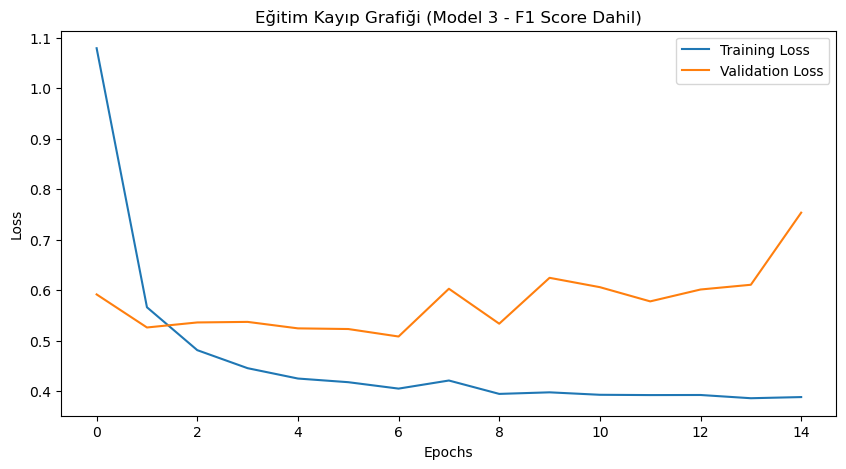

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time
from pathlib import Path


csv_path = r'C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
root_dir = r'C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)'


IMG_SIZE = 128   
batch_size = 32  
learning_rate = 0.001
num_epochs = 15


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BitkiCSVDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['filename']
        label = row['label_encoded']
        
        img_path = self.image_path_dict.get(img_name)
        
        if img_path is None:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
        else:
            try:
                image = Image.open(img_path).convert("RGB")
            except:
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


class BasitBitkiModeli(nn.Module):
    def __init__(self, num_classes):
        super(BasitBitkiModeli, self).__init__()
        
      
        self.features = nn.Sequential(
          
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
           
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        
       
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            
            nn.Linear(128 * 16 * 16, 512), 
            nn.ReLU(),
            
          
            nn.Dropout(0.25), 
            
           
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    
    print(f"\nEğitim Başlıyor ({IMG_SIZE}x{IMG_SIZE}) - F1 Score Aktif...")
    start_time = time.time()
    
    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if (i+1) % 50 == 0: 
                print(f"Epoch {epoch+1} -> {i+1}/{len(train_loader)} adım...", end='\r')
            
            images, labels = images.to(device), labels.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
       
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        
        y_true_list = []
        y_pred_list = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                
                y_true_list.extend(labels.cpu().numpy())
                y_pred_list.extend(predicted.cpu().numpy())
        
  
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total
        
        
        epoch_f1 = f1_score(y_true_list, y_pred_list, average='weighted')
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: %{accuracy:.2f} | F1 Score: {epoch_f1:.4f}")

    print(f"Eğitim Tamamlandı. Süre: {(time.time()-start_time)/60:.1f} dk")
    return train_losses, val_losses


if __name__ == '__main__':
  
    
    print(f"Sistem Kontrolü: {device} üzerinde çalışılıyor.")
    
    
    print("Resim dosyaları taranıyor...")
    image_path_dict = {}
    for path in Path(root_dir).rglob('*'):
        if path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            image_path_dict[path.name] = str(path)
    print(f"Bulunan Resim Sayısı: {len(image_path_dict)}")

   
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        print("HATA: CSV bulunamadı.")
        exit()

    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['class']) 
    class_names = list(le.classes_)
    num_classes = len(class_names)
    print(f"Sınıf Sayısı: {num_classes}")

  
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

    
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = BitkiCSVDataset(train_df, image_path_dict, transform=transform)
    val_dataset = BitkiCSVDataset(val_df, image_path_dict, transform=transform)

    
    use_cuda = torch.cuda.is_available()
    workers = 2 if use_cuda else 0 
    pin_mem = True if use_cuda else False
    
    print(f"Veri Yükleyici Ayarları -> Workers: {workers}, Pin Memory: {pin_mem}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=pin_mem)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=pin_mem)

   
    model = BasitBitkiModeli(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

 
    train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

   
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Eğitim Kayıp Grafiği (Model 3 - F1 Score Dahil)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

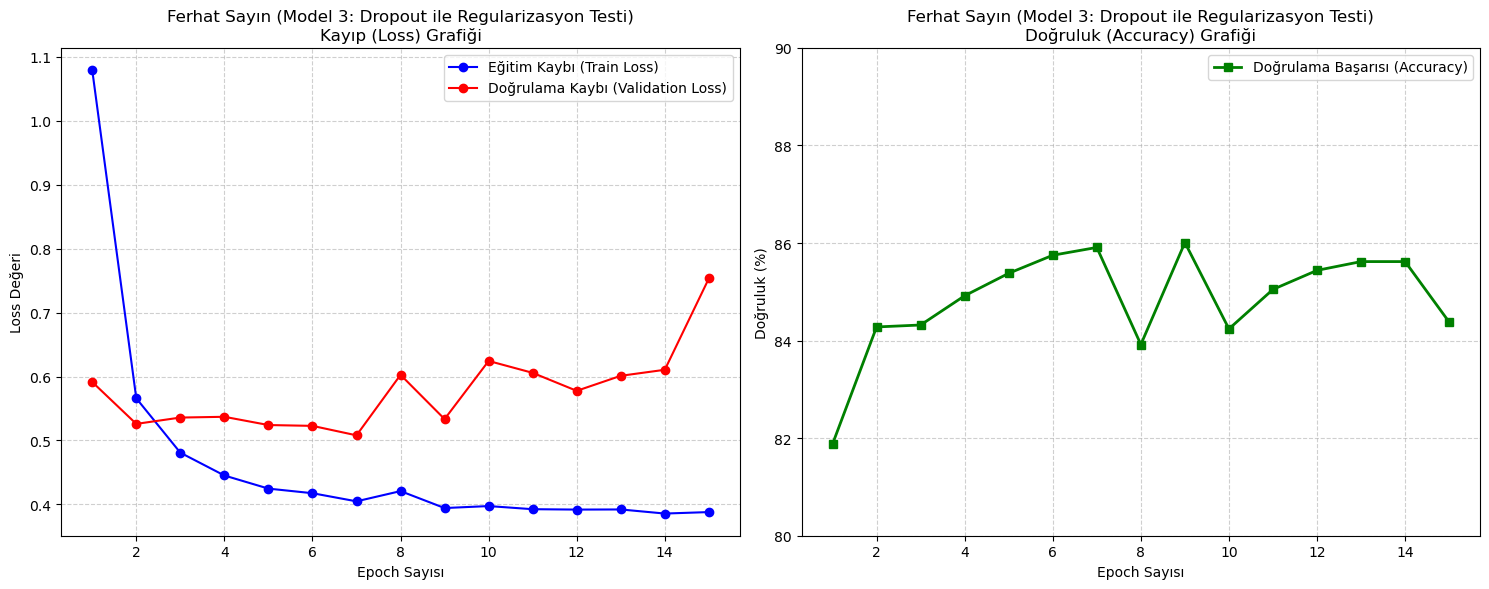

In [1]:
import matplotlib.pyplot as plt


USER_INFO = "Ferhat Sayın (Model 3: Dropout ile Regularizasyon Testi)"


epochs = list(range(1, 16))


train_losses = [
    1.0791, 0.5659, 0.4809, 0.4452, 0.4247, 
    0.4175, 0.4048, 0.4208, 0.3943, 0.3974, 
    0.3925, 0.3919, 0.3921, 0.3857, 0.3880
]


val_losses = [
    0.5914, 0.5259, 0.5358, 0.5370, 0.5241, 
    0.5228, 0.5080, 0.6026, 0.5334, 0.6243, 
    0.6057, 0.5776, 0.6011, 0.6105, 0.7533
]


accuracies = [
    81.88, 84.28, 84.32, 84.92, 85.38, 
    85.75, 85.91, 83.92, 86.01, 84.24, 
    85.05, 85.44, 85.62, 85.62, 84.38
]


plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Eğitim Kaybı (Train Loss)')
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation Loss)')
plt.title(f'{USER_INFO}\nKayıp (Loss) Grafiği', fontsize=12)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Loss Değeri')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')
plt.title(f'{USER_INFO}\nDoğruluk (Accuracy) Grafiği', fontsize=12)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')

plt.ylim(80, 90) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()


plt.show()